<a href="https://colab.research.google.com/github/ericodle/Genre-Classification-Using-LSTM/blob/main/Model_Testing_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WORKING TEST MODULE

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn import functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [ ]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/data_10.json"

In [ ]:
# Specify a path
PATH = "entire_model.pt"


# Load
model = torch.load(DATA_PATH)
model.eval()

SyntaxError: ignored

In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
def train_val_test_split(X, y, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# load data
X, y = load_data(DATA_PATH)

# create train/test split
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.1)

Data succesfully loaded!


In [ ]:
print("train, val, test mfccs")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print("train, val, test targets(labels)")
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

train, val, test mfccs
(7996, 130, 13)
(1000, 130, 13)
(1000, 130, 13)
train, val, test targets(labels)
(7996,)
(1000,)
(1000,)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

tensor_X_train = torch.Tensor(X_train)
tensor_X_val = torch.Tensor(X_val)
tensor_y_train = torch.Tensor(y_train)
tensor_y_val = torch.Tensor(y_val)
tensor_X_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test)

train_dataset = TensorDataset(tensor_X_train,tensor_y_train)
val_dataset = TensorDataset(tensor_X_val,tensor_y_val)
test_dataset = TensorDataset(tensor_X_test,tensor_y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
#Evaluate on test dataset

torch.no_grad()
count = 0
correct = 0

true = []
preds = []

model=model.to(device)

for X_testbatch, y_testbatch in test_dataloader:
    X_testbatch = X_testbatch.to(device)
    y_testbatch = y_testbatch.to(device)

    y_val = model(X_testbatch)
        
    predicted = torch.max(y_val,1)[1]
    
    count+= y_testbatch.size(dim=0)
    correct += (predicted == y_testbatch).sum()

    true.append(y_testbatch)
    preds.append(predicted)

predicted_genres = torch.cat(preds)
ground_truth = torch.cat(true)
print(f'Test accuracy: {correct.item()}/{count} = {correct.item()*100/(count):7.2f}%')


AttributeError: ignored

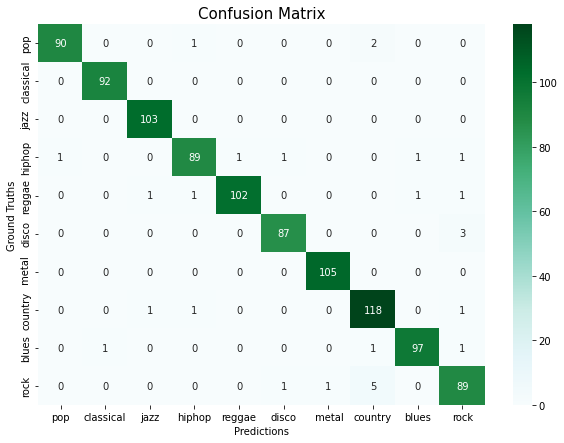

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(ground_truth.view(-1).detach().cpu().numpy(), predicted_genres.view(-1).detach().cpu().numpy())
class_names = ['pop', 'classical', 'jazz', 'hiphop', 'reggae', 'disco', ' metal', 'country', 'blues', 'rock']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.title('Confusion Matrix', fontsize=15)
plt.show() 